###  CORTX Metrics Graphs 

This jupyter notebook creates a few custom interesting graphs and then just does a bulk conversion of every single metric into a graph.

In [2]:
%%capture
%cd /home/johnbent/cortx/metrics
import os
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import cortx_community as cc
import cortx_graphing as cg
import datetime
from github import Github

In [3]:
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams.update({'font.size': 22})
plt.rcParams['lines.markersize'] = 10

In [4]:
# a function which returns a list of all repos for the org which are public and which match a given prefix if one is given
def get_repos(gh,org,prefix=None):
  o = gh.get_organization(org)
  orepos = o.get_repos()
  repos = []
  for repo in orepos:
    match = True
    if repo.private or (prefix and prefix not in repo.name):
        match = False
    if match:
      repos.append(repo)
  return repos

In [5]:
def get_all_repos(gh):
    repos={}
    repos['ceph'] = get_repos(gh=gh,org='ceph')
    repos['daos'] = get_repos(gh=gh, org='daos-stack')
    repos['minio'] = get_repos(gh=gh, org='minio')
    repos['cortx'] = get_repos(gh=gh, org='Seagate', prefix='cortx')
    for r in repos.values():
        print([k.name for k in r])
    return repos

In [6]:
gh = Github(os.environ.get('GH_OATH'))
repos = get_all_repos(gh)

['ceph', 'ceph-qa-chef', 'ceph-client', 'qemu-kvm', 'teuthology', 's3-tests', 'ceph-qa-suite', 'handle_core', 'autobuild-ceph', 'phprados', 'collectd', 'collectd-4.10.1', 'mod_fastcgi', 'apache2', 'ceph-cookbook', 'ceph-client-standalone', 'ceph-build', 'ceph-openstack-tools', 'ceph-autotests', 'barclamp-ceph', 'swift', 'sphinx-ditaa', 'asphyxiate', 'ceph-tools', 'python-cloudfiles', 'rgw-tests', 'sepia', 'leveldb', 'cookbook-gw', 'autotest', 'javaws-kludge', 'cookbook-vercoi', 'libs3', 'downburst', 'keys', 'gitbuilder', 'ceph-kdump-copy', 'propernoun', 'run-crowbar-on-sepia', 'run-chef-on-sepia', 'package-ceph-barclamp', 'cookbook-senta', 'obsync', 'ceph-deploy', 'simplegpt', 'munging_http_proxy', 'samba', 'hadoop-common', 'ceph-nagios-plugin', 'cookbook-vm-general', 'qemu-iotests', 'calamari', 'Diamond', 'pushy', 'radosgw-agent', 'ceph-nagios-plugins', 'rados-java', 'tgt', 'remoto', 'calamari-clients', 'paddles', 'pulpito', 'ice-setup', 'radosgw-apache', 'mongoose', 'puppet-ceph', 'c

In [48]:
# a function which returns a list of days from 0 to last day on which a repo got a star and a list of the star counts on each of those days
def get_stars_or_forks(gh,repos,what):
    dates = {}
    # get all the data
    for r in repos:
        print("Fetching %s for %s" % (what, r.name))
        if what is 'stars':
            items = r.get_stargazers_with_dates()
        else:
            items = r.get_forks()
        for sg in items:
            cc.avoid_rate_limiting(gh)
            if what is 'stars':
                d = sg.starred_at
            else:
                d = sg.created_at
            if d not in dates:
                dates[d]=0
            dates[d] += 1
    # convert all the data
    first_day = None
    last_day = None
    count = 0
    counts={}
    for d in sorted(dates):
        if first_day is None:
            first_day = d
        day = (d - first_day).days
        count += dates[d]
        counts[day] = count
        last_day = day
    days = list(range(last_day+1))
    stars = []
    last_stars=0
    for i in range(last_day+1):
        try:
            last_stars = counts[i]
        except KeyError:
            pass
        stars.append(last_stars)
    return(days,stars)

def get_stars(gh,repos):
    return get_stars_or_forks(gh,repos,'stars')

def get_forks(gh,repos):
    return get_stars_or_forks(gh,repos, 'forks')

In [8]:
(d_days,d_stars) = get_stars(gh,repos['daos'])
(c_days,c_stars) = get_stars(gh,repos['ceph'])
(m_days,m_stars) = get_stars(gh,repos['minio'])
(C_days,C_stars) = get_stars(gh,repos['cortx'])

Fetching stars for daos
Fetching stars for cart
Fetching stars for go-daos
Fetching stars for raft
Fetching stars for go-spdk
Fetching stars for iof
Fetching stars for openpa
Fetching stars for libfabric
Fetching stars for mercury
Fetching stars for mpich
Fetching stars for ishell
Fetching stars for pipeline-lib
Fetching stars for go-ipmctl
Fetching stars for scons_local
Fetching stars for code_review
Fetching stars for ompi
Fetching stars for pmix
Fetching stars for argobots
Fetching stars for pmdk
Fetching stars for fuse
Fetching stars for protobuf-c
Fetching stars for spdk
Fetching stars for fio
Fetching stars for dpdk
Fetching stars for isa-l
Fetching stars for scons
Fetching stars for meson
Fetching stars for python-pathlib
Fetching stars for pdsh
Fetching stars for automake
Fetching stars for daos-stack.github.io
Fetching stars for libtool
Fetching stars for slurm
Fetching stars for munge
Fetching stars for packaging
Fetching stars for isa-l_crypto
Fetching stars for romio
Fetchi

Fetching stars for parquet-go
Fetching stars for spark-select
Fetching stars for minsql
Fetching stars for simple-ci
Fetching stars for spark-benchmarks
Fetching stars for select-simd
Fetching stars for hive-testbench
Fetching stars for nifi-minio
Fetching stars for minio-rs
Fetching stars for select-simd-rs
Fetching stars for HiBench
Fetching stars for rust-hyperscan
Fetching stars for warp
Fetching stars for m3
Fetching stars for radio
Fetching stars for kes
Fetching stars for simdjson-go
Fetching stars for simdjson-fuzz
Fetching stars for sidekick
Fetching stars for console
Fetching stars for bottlenet
Fetching stars for md5-simd
Fetching stars for direct-csi
Fetching stars for k8s-action
Fetching stars for disco
Fetching stars for selfupdate
Fetching stars for charts
Fetching stars for ansible-minio
Fetching stars for hdfs-to-minio
Fetching stars for simdcsv
Fetching stars for dmt
Fetching stars for pkger
Fetching stars for cortx-monitor
Fetching stars for cortx
Fetching stars for 

cortx has    263 stars as of day  275 and had  263 stars on day 263
minio has   2184 stars as of day 38426 and had  263 stars on day 263
 ceph has   3420 stars as of day 15027 and had  263 stars on day 263
 daos has   1558 stars as of day  298 and had  263 stars on day 263
Ceph is largest with size 3421


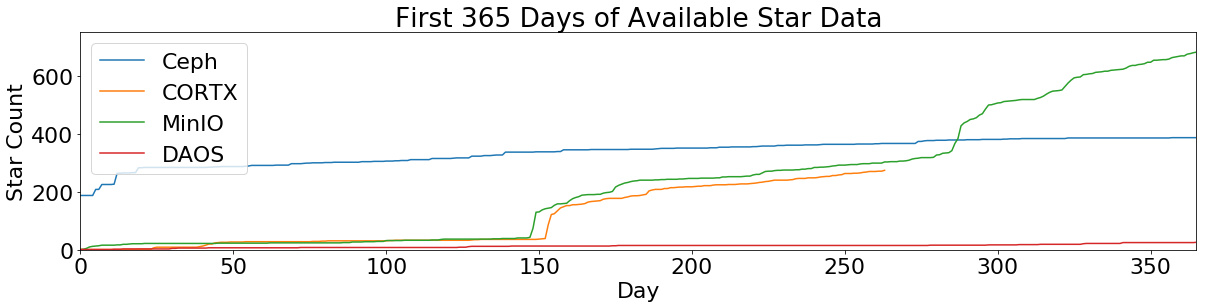

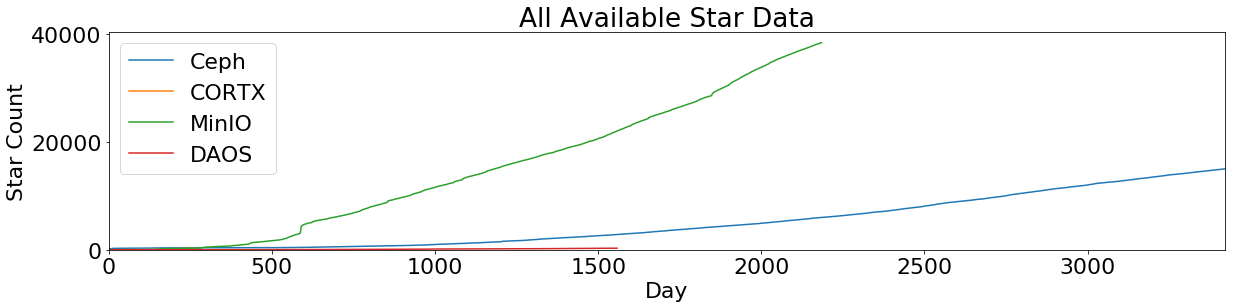

In [80]:
def print_last_day(org,items,days,what,last_day):
    print("%5s has %6d %s as of day %4d and had %4d %s on day %d" % 
          (org,items[-1],what,days[-1],items[last_day],what,last_day))
    
def add_stars_to_df(df,name,stars):
    df1=pd.DataFrame(data={name : stars})
    return pd.concat([df, df1], axis=1) 

def get_dataframe(data):
    largest=0
    name_of_largest = None
    for k,v in data.items():
        if len(v[1]) > largest:
            largest = len(v[1])
            name_of_largest = k
    print("%s is largest with size %d" % (name_of_largest,largest))
    df=pd.DataFrame(index=data[name_of_largest][0],data={ name_of_largest : data[name_of_largest][1] })
    for k,v in data.items():
        if k is not name_of_largest:
            df=add_stars_to_df(df,k,v[1])
    return df

def make_graph(df,data,end_day,title,what):
    if end_day:
        max_y=0
        for v in data.values():
            try:
                max_y = max(max_y,v[1][end_day])
            except IndexError:
                pass
        max_y *= 1.1 # increase it by 10% to add some margin at top of graph
    else:
        max_y=None
    ax=df.plot(xlim=(None,end_day),ylim=(0,max_y),title="%s %s Data" % (title,what))
    ax.set_ylabel('%s Count' % what)
    ax.set_xlabel('Day')
    plt.show()
    
    
    
data = {}
data['Ceph'] = (c_days,c_stars)
data['MinIO'] = (m_days,m_stars)
data['DAOS'] = (d_days,d_stars)
data['CORTX'] = (C_days,C_stars)
for k,v in data.items():
    print_last_day(org=k.lower(),items=v[0],days=v[1],what='stars',last_day=263)
df=get_dataframe(data)
make_graph(df=df,data=data,end_day=365,title="First 365 Days of Available",what='Star')
make_graph(df=df,data=data,end_day=None,title="All Available",what='Star')


In [54]:
for o in ['Ceph','MinIO','DAOS','CORTX']:
    fdata[o]=get_forks(gh,repos[o.lower()])


Fetching forks for minio
Fetching forks for mc
Fetching forks for cli
Fetching forks for minio-go
Fetching forks for minio-java
Fetching forks for minio-js
Fetching forks for minio-py
Fetching forks for minio-dotnet
Fetching forks for attic
Fetching forks for docs
Fetching forks for concert
Fetching forks for minio-js-store-app
Fetching forks for minio-go-media-player
Fetching forks for minio-java-rest-example
Fetching forks for android-photo-app
Fetching forks for swift-photo-app
Fetching forks for ror-resumeuploader-app
Fetching forks for doctor
Fetching forks for awesome-minio
Fetching forks for blake2b-simd
Fetching forks for asm2plan9s
Fetching forks for sha256-simd
Fetching forks for dsync
Fetching forks for minfs
Fetching forks for minio-ruby
Fetching forks for xfile
Fetching forks for perftest
Fetching forks for chaos
Fetching forks for minio-service
Fetching forks for minio-jenkins
Fetching forks for mint
Fetching forks for thumbnailer
Fetching forks for minio-hs
Fetching fork

cortx has    314 forks as of day  110 and had  314 forks on day 110
minio has   5634 forks as of day 2189 and had   17 forks on day 110
 ceph has   8259 forks as of day 3402 and had   30 forks on day 110
 daos has    125 forks as of day 1528 and had    7 forks on day 110
Ceph is largest with size 3403
      Ceph  CORTX  MinIO  DAOS
0        2   27.0    1.0   1.0
1       16   48.0    1.0   1.0
2       17   51.0    2.0   1.0
3       17   68.0    2.0   1.0
4       17   77.0    3.0   1.0
5       17   84.0    3.0   1.0
6       17   89.0    3.0   1.0
7       17   90.0    3.0   1.0
8       17   94.0    3.0   1.0
9       17   94.0    3.0   1.0
10      17  112.0    3.0   1.0
11      17  120.0    3.0   1.0
12      17  123.0    3.0   1.0
13      17  131.0    3.0   1.0
14      17  142.0    3.0   1.0
15      17  143.0    3.0   1.0
16      18  143.0    3.0   1.0
17      18  146.0    3.0   1.0
18      18  148.0    3.0   1.0
19      18  150.0    3.0   1.0
20      18  153.0    3.0   1.0
21      18  154

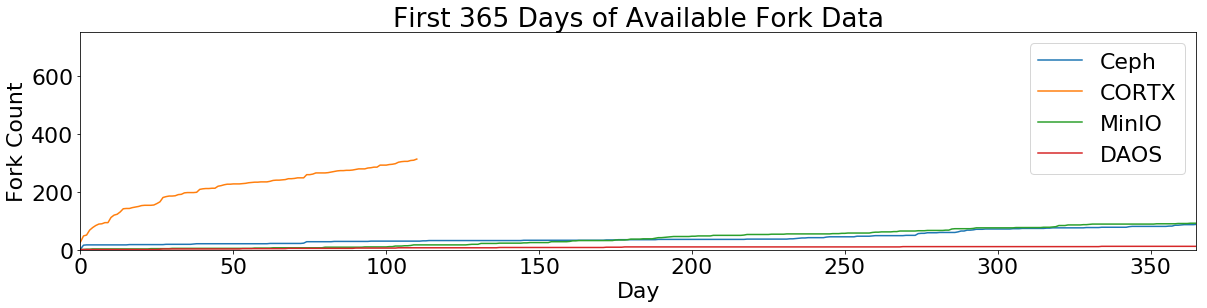

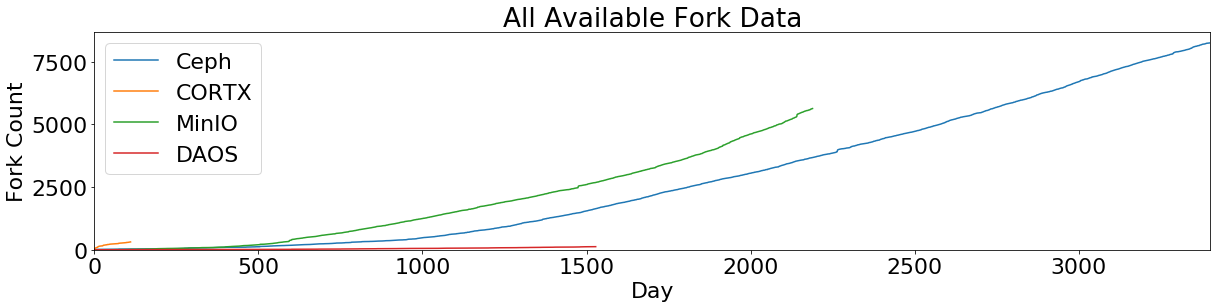

In [81]:
for k,v in fdata.items():
    print_last_day(org=k.lower(),days=v[0],items=v[1],what='forks',last_day=110)
df=get_dataframe(fdata)
print(df)
make_graph(df=df,data=data,end_day=365,title="First 365 Days of Available",what='Fork')
make_graph(df=df,data=data,end_day=None,title="All Available",what='Fork')